<a href="https://colab.research.google.com/github/tbeucler/2024_MLEES_Ebook/blob/main/Haokun/lam_graphcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  (Exercise) Neural Weather prediction



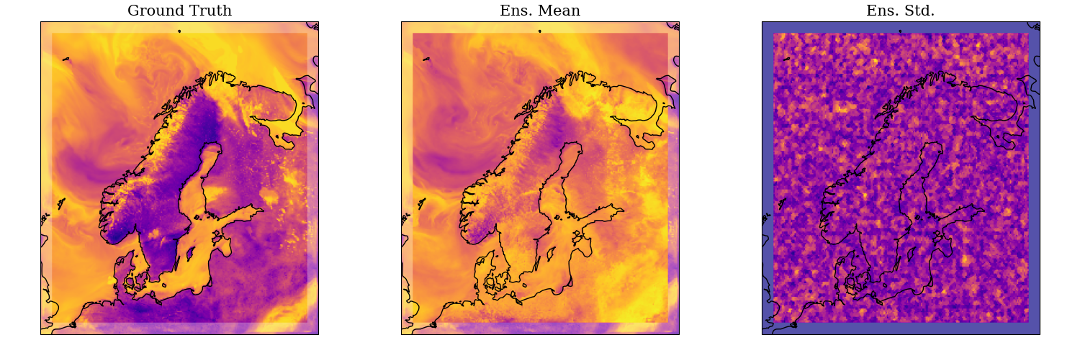





*Figure: One of the weather prediction results after training the GNN models in this exercise.*

This notebook is converted from this Github branch: https://github.com/mllam/neural-lam/tree/prob_model_lam

### Introduction

By the end of this notebook, you’ll be able to:

1.   Construct GNN models to predict the weather;
2.   Engage in loading trained models structures;
3.   Try to be familiar the PyTorch framework;
4.   Further develop your skills in writing function.

**Graph Neural Networks** (GNNs) have emerged as an innovative tool for weather prediction to model the inherented complex spatial dependencies. Traditional methods often struggle to capture the intricate relationships between atmospheric variables across vast geographical regions. By representing these regions as nodes and their interactions as edges, GNNs can effectively model the spatial-temporal correlations that drive weather patterns.

However, the adoption of GNNs in weather prediction is not without challenges. High-resolution meteorological data is essential to unlock their full potential, and the computational demands of GNNs can be significant. Nevertheless, their integration with other deep learning frameworks has shown remarkable potential, enhancing the accuracy and scalability of forecasting systems.

In this exercise, we will use the MEPS dataset for limited area model through the graph-based probabilistic weather prediction. MEPS dataset explaination The weather forecasting model for the Nordic area is the MetCoOp Ensemble Prediction System (**MEPS**). **MEPS** is the Meteorological Cooperation on Operational Numeric Weather Prediction (NWP) between meteorological institutes at Finland, Norway, Sweden and Estonia. It has a horizontal resolution of 2.5 kilometers.

The probabilistic models are intended to provide a range of possibilities. This complements the existing forecast methods in order to better communicate forecast uncertainties before and during weather events. For example, you may see your local forecast saying low temperature of -10°C. This is the official NWS forecast, but there is still uncertainty. The probabilistic information can help you understand more about this uncertainty to make informed decisions. This range of possibilities is important to consider when planning and making your decisions. For instance, if the forecast low temperature for your location is -10°C, but there is still a possibility you could see a low of -15°C, then you may want to consider preparing to protect tender vegetation for a possible freeze.

Traditional forecasts have only given a single forecast for temperature and precipitation, though they can change from day to day as the event approaches. The goal of probabilistic weather forecast models is to provide the "Goal Posts", or range of possibilities for a specific event. That's the reason why people explore it through graph neural networks.

**References**:

Lam, Remi, Alvaro Sanchez-Gonzalez, Matthew Willson, Peter Wirnsberger, Meire Fortunato, Ferran Alet, Suman Ravuri et al. "Learning skillful medium-range global weather forecasting." _Science_ 382, no. 6677 (2023): 1416-1421.

Oskarsson, J., Landelius, T., & Lindsten, F. (2023). Graph-based Neural Weather Prediction for Limited Area Modeling. NeurIPS 2023 Workshop on Tackling Climate Change with Machine Learning, New Orleans, Louisiana, United States, _arXiv:2309.17370_.

Oskarsson, J., Landelius, T., Deisenroth, M. & Lindsten, F. (2024). Probabilistic Weather Forecasting with Hierarchical Graph Neural Networks. NeurIPS 2024, Vancouver, Canada, _arXiv:2406.04759_.

### Set-up environment

Follow the steps below to create the necessary python environment and save dataset for our interesting journey of Graph neural networks :)

*   Connect to your Google Drive
*   Download the dataset and necessary codes
*   Always remember to use python 3.10. (Colab fit it)
*   Install version 2.0.1 of PyTorch, version 117 of CUDA.
*   Install required packages specified as below.
*   Install PyTorch Geometric version 2.3.1.

In [1]:
# First we should connect the GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Download the dataset and remember to upload them to your GOOGLE DRIVE
import pooch

data_url = 'https://unils-my.sharepoint.com/:u:/g/personal/haokun_liu_unil_ch/EVp6Oym5i_RElMf7jYz9VboB7ZdpyYKuTlBWLeVq9fyPTA?e=qMibgG&download=1'
hash = 'ad511b41c3d705e6353fe79f5a4c1bae4092844e221ed7cdbff2fc2d0e7075df'
data = pooch.retrieve(data_url, known_hash = hash, processor=pooch.Unzip())

In [ ]:
# Check the current version of torch in your colab; if the torch is 2.0.1 and cuda is 117, we can continue; Otherwise, you should check the below steps
import torch
print(torch.__version__)

In [ ]:
# Uninstall the current version of torch and cuda for your GPU at Colab, because we need to adjust
!pip uninstall -y torch torchvision torchaudio

In [ ]:
# Adjust the version for the corresponding coding environment (i.e., torch must 2.0.1, and other should be corresponding)
!pip install torch==2.0.1 torchvision torchaudio torchtext

In [ ]:
# Load the necessary packages, based on the requirements of the model
!pip install pytorch-lightning==2.0.3
!pip install Cartopy==0.22.0
!pip install tueplots==0.0.8
!pip install codespell==2.0.0
!pip install black==21.9b0
!pip install isort==5.9.3
!pip install flake8==4.0.1
!pip install pylint==3.0.3
!pip install pre-commit==2.15.0

# Install PyTorch Geometric version 2.2.0

!pip install pyg-lib==0.2.0 torch-scatter==2.1.1 torch-sparse==0.6.17 torch-cluster==1.6.1\
    torch-geometric==2.3.1 -f https://pytorch-geometric.com/whl/torch-2.0.1+cu117.html

### Q1: Creating the graph

As we learnt, if we want to implement GNNs, we need to create the graph first. Thus, we should define the function for creating the graphs.

In this question, we will guide you work on four parts:

*   Visualize the graph structure in the context of the larger program
*   Save the edges‘ index and features via Torch
*   Creates a 2D directed graph with a regular grid structure
*   Save the code in your work path



In [ ]:
# Standard library
import os
from argparse import ArgumentParser

# Third-party
import matplotlib
import matplotlib.pyplot as plt
import networkx
import numpy as np
import scipy.spatial
import torch
import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx


def plot_graph(graph, title=None):
    fig, axis = plt.subplots(figsize=(8, 8), dpi=200)  # W,H
    edge_index = graph.edge_index
    pos = graph.pos

    # Fix for re-indexed edge indices only containing mesh nodes at
    # higher levels in hierarchy
    edge_index = edge_index - edge_index.min()

    if pyg.utils.is_undirected(edge_index):
        # Keep only 1 direction of edge_index
        edge_index = edge_index[:, edge_index[0] < edge_index[1]]  # (2, M/2)
    # TODO: indicate direction of directed edges

    # Move all to cpu and numpy, compute (in)-degrees

      ############# Your code here ############
      ## Note:
      ## 1: Please use the function 'pyg.utils.degree' to compute the degrees
      ## 2: Remember to move degrees, edge index, and pos to cpu and then convert them as numpy arrays
      #########################################

    # Plot edges
    from_pos = pos[edge_index[0]]  # (M/2, 2)
    to_pos = pos[edge_index[1]]  # (M/2, 2)
    edge_lines = np.stack((from_pos, to_pos), axis=1)
    axis.add_collection(
        matplotlib.collections.LineCollection(
            edge_lines, lw=0.4, colors="black", zorder=1
        )
    )

    # Plot nodes
    node_scatter = axis.scatter(
        pos[:, 0],
        pos[:, 1],
        c=degrees,
        s=3,
        marker="o",
        zorder=2,
        cmap="viridis",
        clim=None,
    )

    plt.colorbar(node_scatter, aspect=50)

    if title is not None:
        axis.set_title(title)

    return fig, axis


def sort_nodes_internally(nx_graph):
    # For some reason the networkx .nodes() return list can not be sorted,
    # but this is the ordering used by pyg when converting.
    # This function fixes this.
    H = networkx.DiGraph()
    H.add_nodes_from(sorted(nx_graph.nodes(data=True)))
    H.add_edges_from(nx_graph.edges(data=True))
    return H


def save_edges(graph, name, base_path):
      ############# Your code here ############
      ## Note:
      ## 1: Use the torch.save function to save the edge indices of the graph as '.pt' file in the specified base path
      ## 2: Create a tensor of edge features by concatenating two attributes: length of each edge 'len.unsqueeze(1)' and vector difference 'vdiff', save as float32
      ## 3: Same as before, remember to save the edge features tensor created in Step 2, and also need to be saved as the '.pt' file in the specified base path
      ## Hint: If necessary, you can check the below function for how to save edges list to prepare this one
      #########################################

def save_edges_list(graphs, name, base_path):
    torch.save(
        [graph.edge_index for graph in graphs],
        os.path.join(base_path, f"{name}_edge_index.pt"),
    )
    edge_features = [
        torch.cat((graph.len.unsqueeze(1), graph.vdiff), dim=1).to(
            torch.float32
        )
        for graph in graphs
    ]  # Save as float32
    torch.save(edge_features, os.path.join(base_path, f"{name}_features.pt"))


def from_networkx_with_start_index(nx_graph, start_index):
    pyg_graph = from_networkx(nx_graph)
    pyg_graph.edge_index += start_index
    return pyg_graph

# This mk_2d_graph function essentially creates a 2D directed graph with a regular grid structure, including diagonal connections.
# Each edge has associated length and vector difference attributes, which can be useful for various graph-based computations or analyses.

def mk_2d_graph(xy, nx, ny):
    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])

    # avoid nodes on border,it calculates a grid with nodes slightly inset from the edges, then will assign the position of the nodes:
    dx = (xM - xm) / nx
    dy = (yM - ym) / ny
    lx = np.linspace(xm + dx / 2, xM - dx / 2, nx)
    ly = np.linspace(ym + dy / 2, yM - dy / 2, ny)

    ############# Your code here ############
    ## Note:
    ## 1: Create the 2D meshgrid mg using numpy function
    ## 2: Create the 2D grid graph using networkx function
    ## 3: Assign the node positions based on the meshgrid corrdinates through 'for' loop
    #########################################

    # add diagonal edges
    g.add_edges_from(
        [((x, y), (x + 1, y + 1)) for x in range(nx - 1) for y in range(ny - 1)]
        + [
            ((x + 1, y), (x, y + 1))
            for x in range(nx - 1)
            for y in range(ny - 1)
        ]
    )

    ############# Your code here ############
    ## Note:
    ## 1: The graph should be converted to a directed graph 'dg' (Hint: considering the function in networkx)
    ## 2: For each edge in the original undirected graph, we can use the nodes 'u' and 'v' to loop all:
    ##    - The edge length (len) is calculated as the Euclidean distance between nodes.
    ##    - The vector difference (vdiff) between node positions is calculated.
    ##    - Edges are added in both directions (making it directed) with the same length but opposite vector differences.
    ## 3: Remember to calculate all the edges
    #########################################

def prepend_node_index(graph, new_index):
    # Relabel node indices in graph, insert (graph_level, i, j)
    ijk = [tuple((new_index,) + x) for x in graph.nodes]
    to_mapping = dict(zip(graph.nodes, ijk))
    return networkx.relabel_nodes(graph, to_mapping, copy=True)


def main():
    parser = ArgumentParser(description="Graph generation arguments")
    parser.add_argument(
        "--dataset",
        type=str,
        default="meps_example",
        help="Dataset to load grid point coordinates from "
        "(default: meps_example)",
    )
    parser.add_argument(
        "--graph",
        type=str,
        default="multiscale",
        help="Name to save graph as (default: multiscale)",
    )
    parser.add_argument(
        "--plot",
        type=int,
        default=0,
        help="If graphs should be plotted during generation "
        "(default: 0 (false))",
    )
    parser.add_argument(
        "--levels",
        type=int,
        help="Limit multi-scale mesh to given number of levels, "
        "from bottom up (default: None (no limit))",
    )
    parser.add_argument(
        "--hierarchical",
        type=int,
        default=0,
        help="Generate hierarchical mesh graph (default: 0, no)",
    )
    args = parser.parse_args()

    # Load grid positions
    static_dir_path = os.path.join("data", args.dataset, "static")
    graph_dir_path = os.path.join("graphs", args.graph)
    os.makedirs(graph_dir_path, exist_ok=True)

    xy = np.load(os.path.join(static_dir_path, "nwp_xy.npy"))

    grid_xy = torch.tensor(xy)
    pos_max = torch.max(torch.abs(grid_xy))

    #
    # Mesh
    #

    # graph geometry
    nx = 3  # number of children = nx**2
    nlev = int(np.log(max(xy.shape)) / np.log(nx))
    nleaf = nx**nlev  # leaves at the bottom = nleaf**2

    mesh_levels = nlev - 1
    if args.levels:
        # Limit the levels in mesh graph
        mesh_levels = min(mesh_levels, args.levels)

    print(f"nlev: {nlev}, nleaf: {nleaf}, mesh_levels: {mesh_levels}")

    # multi resolution tree levels
    G = []
    for lev in range(1, mesh_levels + 1):
        n = int(nleaf / (nx**lev))
        g = mk_2d_graph(xy, n, n)
        if args.plot:
            plot_graph(from_networkx(g), title=f"Mesh graph, level {lev}")
            plt.show()

        G.append(g)

    if args.hierarchical:
        # Relabel nodes of each level with level index first
        G = [
            prepend_node_index(graph, level_i)
            for level_i, graph in enumerate(G)
        ]

        num_nodes_level = np.array([len(g_level.nodes) for g_level in G])
        # First node index in each level in the hierarchical graph
        first_index_level = np.concatenate(
            (np.zeros(1, dtype=int), np.cumsum(num_nodes_level[:-1]))
        )

        # Create inter-level mesh edges
        up_graphs = []
        down_graphs = []
        for from_level, to_level, G_from, G_to, start_index in zip(
            range(1, mesh_levels),
            range(0, mesh_levels - 1),
            G[1:],
            G[:-1],
            first_index_level[: mesh_levels - 1],
        ):
            # start out from graph at from level
            G_down = G_from.copy()
            G_down.clear_edges()
            G_down = networkx.DiGraph(G_down)

            # Add nodes of to level
            G_down.add_nodes_from(G_to.nodes(data=True))

            # build kd tree for mesh point pos
            # order in vm should be same as in vm_xy
            v_to_list = list(G_to.nodes)
            v_from_list = list(G_from.nodes)
            v_from_xy = np.array([xy for _, xy in G_from.nodes.data("pos")])
            kdt_m = scipy.spatial.KDTree(v_from_xy)

            # add edges from mesh to grid
            for v in v_to_list:
                # find 1(?) nearest neighbours (index to vm_xy)
                neigh_idx = kdt_m.query(G_down.nodes[v]["pos"], 1)[1]
                u = v_from_list[neigh_idx]

                # add edge from mesh to grid
                G_down.add_edge(u, v)
                d = np.sqrt(
                    np.sum(
                        (G_down.nodes[u]["pos"] - G_down.nodes[v]["pos"]) ** 2
                    )
                )
                G_down.edges[u, v]["len"] = d
                G_down.edges[u, v]["vdiff"] = (
                    G_down.nodes[u]["pos"] - G_down.nodes[v]["pos"]
                )

            # relabel nodes to integers (sorted)
            G_down_int = networkx.convert_node_labels_to_integers(
                G_down, first_label=start_index, ordering="sorted"
            )  # Issue with sorting here
            G_down_int = sort_nodes_internally(G_down_int)
            pyg_down = from_networkx_with_start_index(G_down_int, start_index)

            # Create up graph, invert downwards edges
            up_edges = torch.stack(
                (pyg_down.edge_index[1], pyg_down.edge_index[0]), dim=0
            )
            pyg_up = pyg_down.clone()
            pyg_up.edge_index = up_edges

            up_graphs.append(pyg_up)
            down_graphs.append(pyg_down)

            if args.plot:
                plot_graph(
                    pyg_down, title=f"Down graph, {from_level} -> {to_level}"
                )
                plt.show()

                plot_graph(
                    pyg_down, title=f"Up graph, {to_level} -> {from_level}"
                )
                plt.show()

        # Save up and down edges
        save_edges_list(up_graphs, "mesh_up", graph_dir_path)
        save_edges_list(down_graphs, "mesh_down", graph_dir_path)

        # Extract intra-level edges for m2m
        m2m_graphs = [
            from_networkx_with_start_index(
                networkx.convert_node_labels_to_integers(
                    level_graph, first_label=start_index, ordering="sorted"
                ),
                start_index,
            )
            for level_graph, start_index in zip(G, first_index_level)
        ]

        mesh_pos = [graph.pos.to(torch.float32) for graph in m2m_graphs]

        # For use in g2m and m2g
        G_bottom_mesh = G[0]

        joint_mesh_graph = networkx.union_all([graph for graph in G])
        all_mesh_nodes = joint_mesh_graph.nodes(data=True)

    else:
        # combine all levels to one graph
        G_tot = G[0]
        for lev in range(1, len(G)):
            nodes = list(G[lev - 1].nodes)
            n = int(np.sqrt(len(nodes)))
            ij = (
                np.array(nodes)
                .reshape((n, n, 2))[1::nx, 1::nx, :]
                .reshape(int(n / nx) ** 2, 2)
            )
            ij = [tuple(x) for x in ij]
            G[lev] = networkx.relabel_nodes(G[lev], dict(zip(G[lev].nodes, ij)))
            G_tot = networkx.compose(G_tot, G[lev])

        # Relabel mesh nodes to start with 0
        G_tot = prepend_node_index(G_tot, 0)

        # relabel nodes to integers (sorted)
        G_int = networkx.convert_node_labels_to_integers(
            G_tot, first_label=0, ordering="sorted"
        )

        # Graph to use in g2m and m2g
        G_bottom_mesh = G_tot
        all_mesh_nodes = G_tot.nodes(data=True)

        # export the nx graph to PyTorch geometric
        pyg_m2m = from_networkx(G_int)
        m2m_graphs = [pyg_m2m]
        mesh_pos = [pyg_m2m.pos.to(torch.float32)]

        if args.plot:
            plot_graph(pyg_m2m, title="Mesh-to-mesh")
            plt.show()

    # Save m2m edges
    save_edges_list(m2m_graphs, "m2m", graph_dir_path)

    # Divide mesh node pos by max coordinate of grid cell
    mesh_pos = [pos / pos_max for pos in mesh_pos]

    # Save mesh positions
    torch.save(
        mesh_pos, os.path.join(graph_dir_path, "mesh_features.pt")
    )  # mesh pos, in float32

    #
    # Grid2Mesh
    #

    # radius within which grid nodes are associated with a mesh node
    # (in terms of mesh distance)
    DM_SCALE = 0.67

    # mesh nodes on lowest level
    vm = G_bottom_mesh.nodes
    vm_xy = np.array([xy for _, xy in vm.data("pos")])
    # distance between mesh nodes
    dm = np.sqrt(
        np.sum((vm.data("pos")[(0, 1, 0)] - vm.data("pos")[(0, 0, 0)]) ** 2)
    )

    # grid nodes
    Ny, Nx = xy.shape[1:]

    G_grid = networkx.grid_2d_graph(Ny, Nx)
    G_grid.clear_edges()

    # vg features (only pos introduced here)
    for node in G_grid.nodes:
        # pos is in feature but here explicit for convenience
        G_grid.nodes[node]["pos"] = np.array([xy[0][node], xy[1][node]])

    # add 1000 to node key to separate grid nodes (1000,i,j) from mesh nodes
    # (i,j) and impose sorting order such that vm are the first nodes
    G_grid = prepend_node_index(G_grid, 1000)

    # build kd tree for grid point pos
    # order in vg_list should be same as in vg_xy
    vg_list = list(G_grid.nodes)
    vg_xy = np.array([[xy[0][node[1:]], xy[1][node[1:]]] for node in vg_list])
    kdt_g = scipy.spatial.KDTree(vg_xy)

    # now add (all) mesh nodes, include features (pos)
    G_grid.add_nodes_from(all_mesh_nodes)

    # Re-create graph with sorted node indices
    # Need to do sorting of nodes this way for indices to map correctly to pyg
    G_g2m = networkx.Graph()
    G_g2m.add_nodes_from(sorted(G_grid.nodes(data=True)))

    # turn into directed graph
    G_g2m = networkx.DiGraph(G_g2m)

    # add edges
    for v in vm:
        # find neighbours (index to vg_xy)
        neigh_idxs = kdt_g.query_ball_point(vm[v]["pos"], dm * DM_SCALE)
        for i in neigh_idxs:
            u = vg_list[i]
            # add edge from grid to mesh
            G_g2m.add_edge(u, v)
            d = np.sqrt(
                np.sum((G_g2m.nodes[u]["pos"] - G_g2m.nodes[v]["pos"]) ** 2)
            )
            G_g2m.edges[u, v]["len"] = d
            G_g2m.edges[u, v]["vdiff"] = (
                G_g2m.nodes[u]["pos"] - G_g2m.nodes[v]["pos"]
            )

    pyg_g2m = from_networkx(G_g2m)

    if args.plot:
        plot_graph(pyg_g2m, title="Grid-to-mesh")
        plt.show()

    #
    # Mesh2Grid
    #

    # start out from Grid2Mesh and then replace edges
    G_m2g = G_g2m.copy()
    G_m2g.clear_edges()

    # build kd tree for mesh point pos
    # order in vm should be same as in vm_xy
    vm_list = list(vm)
    kdt_m = scipy.spatial.KDTree(vm_xy)

    # add edges from mesh to grid
    for v in vg_list:
        # find 4 nearest neighbours (index to vm_xy)
        neigh_idxs = kdt_m.query(G_m2g.nodes[v]["pos"], 4)[1]
        for i in neigh_idxs:
            u = vm_list[i]
            # add edge from mesh to grid
            G_m2g.add_edge(u, v)
            d = np.sqrt(
                np.sum((G_m2g.nodes[u]["pos"] - G_m2g.nodes[v]["pos"]) ** 2)
            )
            G_m2g.edges[u, v]["len"] = d
            G_m2g.edges[u, v]["vdiff"] = (
                G_m2g.nodes[u]["pos"] - G_m2g.nodes[v]["pos"]
            )

    # relabel nodes to integers (sorted)
    G_m2g_int = networkx.convert_node_labels_to_integers(
        G_m2g, first_label=0, ordering="sorted"
    )
    pyg_m2g = from_networkx(G_m2g_int)

    if args.plot:
        plot_graph(pyg_m2g, title="Mesh-to-grid")
        plt.show()

    # Save g2m and m2g everything
    # g2m
    save_edges(pyg_g2m, "g2m", graph_dir_path)
    # m2g
    save_edges(pyg_m2g, "m2g", graph_dir_path)


if __name__ == "__main__":
    main()


Now, after editing the previous code block, we should save it as the '.py' file for the further prediction.

Remember to save it as '**create_mesh.py**' and in **the correct path**.

In [ ]:
############# Your code here ############
## Note:
## 1: Save the previous code block as '.py' file, named it as 'create_mesh.py'.
## 2: Save it in the correct path (i.e., .../neural-lam-prob_model_lam/)
#########################################

### Q2: Creating the grid features

Meanwhile, based on the previous grids and graph, we also need to have the features.

In this question, we will guide you to design the function to pre-compute and save static features related to a grid, which will be used for the next GNN tasks:


*  Load, flatten, and normalize the necessary features
    *   Load and process grid features
    *   Load geopotential features
    *   Border mask
*  Combine these features
*  Save pre-computed features



In [ ]:
# Standard library
import os
from argparse import ArgumentParser

# Third-party
import numpy as np
import torch


def main():
    """
    Pre-compute all static features related to the grid nodes
    """
    parser = ArgumentParser(description="Training arguments")
    parser.add_argument(
        "--dataset",
        type=str,
        default="meps_example",
        help="Dataset to compute weights for (default: meps_example)",
    )
    args = parser.parse_args()

    static_dir_path = os.path.join("data", args.dataset, "static")

    # -- Static grid node features --

    ############# Your code here ############
    ## Note:
    ## 1: You should use the torch.tensor to load all necessary data.
    ## 2: You can find the related static features in this path (as indicated before: ".../neural-lam-prob_model_lam/data/meps_example/static/...")
    ## 3: When you load them, you can check the numpy array first for the flatten steps.
    ## 4: 'torch.cat' function will help you to concatenate grid features.
    ## 5: Remember to save the features in the static path.
    #########################################

    # Grid Coordinates


    # Geopotential Height


    # Border mask


    # Concatenate grid features


    # Save grid features



if __name__ == "__main__":
    main()


Now, after editing the previous code block, we should save it as the '.py' file for the further prediction.

Remember to save it as '**create_grid_features.py**' and in **the correct path**.

In [ ]:
############# Your code here ############
## Note:
## 1: Save the previous code block as '.py' file, named it as 'create_grid_features.py'.
## 2: Save it in the correct path (i.e., .../neural-lam-prob_model_lam/neural_lam/)
#########################################

### Q3: Calculating the feature statistics

Perfect! Now we have the function to create the graph and grid features.

Although we will use the trained models for GNNs prediction, we also need to understand the **parameter weights** and **related statistics** for **each parameters**. In our exercise, we will get the statistics (i.e., mean and standard deviation) for the weather parameter (e.g., temperature) and flux forcing (i.e., specific components of weather models)

Meanwhile, the **one-step differences** method is also essential for us, because when we computes statistical metrics for time-step differences, it will help ue to capture temporal changes in the data.

That's the purposes of this question for you to follow the exercise.

To evaluate these GNN models, the authors conduct expriments on both global and limited area forecasting. The models are implemented in PyTorch and trained on 8 A100 80GB GPUs in a data-parallel configuration. Training takes **700-1400 total GPU-hours** for **the global models**, and around **half of that** for **the limited area models**.

That is the reason why they implement the **batched sampling** on a single GPU to reduce the resource demand. Using this strategy, 80 ensemble members are produced in 200s (2.5s per member) for global forecasting.

In [ ]:
# Standard library
import os
from argparse import ArgumentParser

# Third-party
import numpy as np
import torch
from tqdm import tqdm

# First-party
from neural_lam import constants
from neural_lam.weather_dataset import WeatherDataset


def main():
    """
    Pre-compute parameter weights to be used in loss function
    """

    # Part 01: Argument parsing
    parser = ArgumentParser(description="Training arguments")
    parser.add_argument(
        "--dataset",
        type=str,
        default="meps_example",
        help="Dataset to compute weights for (default: meps_example)",
    )
    parser.add_argument(
        "--batch_size",
        type=int,
        default=32,
        help="Batch size when iterating over the dataset",
    )
    parser.add_argument(
        "--step_length",
        type=int,
        default=3,
        help="Step length in hours to consider single time step (default: 3)",
    )
    parser.add_argument(
        "--n_workers",
        type=int,
        default=4,
        help="Number of workers in data loader (default: 4)",
    )
    args = parser.parse_args()

    static_dir_path = os.path.join("data", args.dataset, "static")

    # Part 02: Pre-compute parameter weights
    # Create parameter weights based on height
    # based on fig A.1 in graph cast paper
    w_dict = {
        "2": 1.0,
        "0": 0.1,
        "65": 0.065,
        "1000": 0.1,
        "850": 0.05,
        "500": 0.03,
    }
    w_list = np.array(
        [w_dict[par.split("_")[-2]] for par in constants.PARAM_NAMES]
    )
    print("Saving parameter weights...")
    np.save(
        os.path.join(static_dir_path, "parameter_weights.npy"),
        w_list.astype("float32"),
    )

    # Part 03: Calculate necessary statistics
    # Load dataset without any subsampling
    ds = WeatherDataset(
        args.dataset,
        split="train",
        subsample_step=1,
        pred_length=63,
        standardize=False,
    )  # Without standardization
    # Divide the dataset into batches for efficient processing
    loader = torch.utils.data.DataLoader(
        ds, args.batch_size, shuffle=False, num_workers=args.n_workers
    )

    # Compute mean and std.-dev. of each parameter (+ flux forcing)
    # across full dataset
    print("Computing mean and std.-dev. for parameters...")
    means = []
    squares = []
    flux_means = []
    flux_squares = []

    ############# Your code here ############
    ## Note:
    ## 1: Based on the previous batches division, you should use the 'init_batch', 'target_batch', and 'forcing_batch' to finish the process.
    ## 2: Meanwhile, you also need to use the 'tqdm()' function to proceed the loop, which is good to check the progressbar.
    ## 3: Remember to use the 'torch.cat', which is always useful, especially for you to prepare the batch including the initial and target batch.
    ## 4: Compute the mean and squared values for each feature across the dataset via Torch.
    ## 5: Computes mean and squared values for the forcing, then remember to extract them into the forcing batch.
    ## 6: Finally aggregate batch-wise statistics to compute global mean and standard deviation, and also flux part (Hint: you can use 'torch.stack()' function).
    ## 7: If necessary, you can check the below loop for the one-difference method to get the similar logic for this loop.
    #########################################

    for init_batch, target_batch, forcing_batch in tqdm(loader):
    ############# Your code here ############

    #########################################

        # Flux at 1st windowed position is index 1 in forcing
        flux_batch = forcing_batch[:, :, :, 1]
        ############# Your code here ############

        #########################################

    ############# Your code here ############

    #########################################

    print("Saving mean, std.-dev, flux_stats...")
    torch.save(mean, os.path.join(static_dir_path, "parameter_mean.pt"))
    torch.save(std, os.path.join(static_dir_path, "parameter_std.pt"))
    torch.save(flux_stats, os.path.join(static_dir_path, "flux_stats.pt"))

    # Compute mean and std.-dev. of one-step differences across the dataset
    print("Computing mean and std.-dev. for one-step differences...")
    ds_standard = WeatherDataset(
        args.dataset,
        split="train",
        subsample_step=1,
        pred_length=63,
        standardize=True,
    )  # Re-load with standardization
    loader_standard = torch.utils.data.DataLoader(
        ds_standard, args.batch_size, shuffle=False, num_workers=args.n_workers
    )
    used_subsample_len = (65 // args.step_length) * args.step_length

    diff_means = []
    diff_squares = []
    for init_batch, target_batch, _ in tqdm(loader_standard):
        batch = torch.cat(
            (init_batch, target_batch), dim=1
        )  # (N_batch, N_t', N_grid, d_features)
        # Note: batch contains only 1h-steps
        stepped_batch = torch.cat(
            [
                batch[:, ss_i : used_subsample_len : args.step_length]
                for ss_i in range(args.step_length)
            ],
            dim=0,
        )
        # (N_batch', N_t, N_grid, d_features),
        # N_batch' = args.step_length*N_batch

        batch_diffs = stepped_batch[:, 1:] - stepped_batch[:, :-1]
        # (N_batch', N_t-1, N_grid, d_features)

        diff_means.append(
            torch.mean(batch_diffs, dim=(1, 2))
        )  # (N_batch', d_features,)
        diff_squares.append(
            torch.mean(batch_diffs**2, dim=(1, 2))
        )  # (N_batch', d_features,)

    diff_mean = torch.mean(torch.cat(diff_means, dim=0), dim=0)  # (d_features)
    diff_second_moment = torch.mean(torch.cat(diff_squares, dim=0), dim=0)
    diff_std = torch.sqrt(diff_second_moment - diff_mean**2)  # (d_features)

    print("Saving one-step difference mean and std.-dev...")
    torch.save(diff_mean, os.path.join(static_dir_path, "diff_mean.pt"))
    torch.save(diff_std, os.path.join(static_dir_path, "diff_std.pt"))


if __name__ == "__main__":
    main()


Now, after editing the previous code block, we should save it as the '.py' file for the further prediction.

Remember to save it as '**create_parameter_weight.py**' and in **the correct path**.

In [ ]:
############# Your code here ############
## Note:
## 1: Save the previous code block as '.py' file, named it as 'create_parameter_weight.py'.
## 2: Save it in the correct path (i.e., .../neural-lam-prob_model_lam/)
#########################################

### Q4: Model training

After long exploration, we can start to train our GNN models finally. Take care yourself and prepare some coffee because it will cost long time!

In this exercise, we will mainly train two GNN models and compare them. One is the **GraphCast**, the other one is the **Graph-FM** (Deterministic model using hierarchical graph).

**GraphCast**, a state-of-the-art AI model able to make medium-range weather forecasts with unprecedented accuracy (i.e., predicting weather conditions up to 10 days in advance ). Meanwhile, it can also offer earlier warnings of extreme weather events. It can predict the tracks of cyclones with great accuracy further into the future, identifies atmospheric rivers associated with flood risk, and predicts the onset of extreme temperatures.

While most existing Neural Weather Prediction (NeurWP) methods focus on global forecasting, an important question is how these techniques can be applied to limited area modeling (LAM). Thus, the authors adapt the graph-based NeurWP approach to the limited area setting and propose a multi-scale hierarchical model extension for **Graph-FM** model, which is validated by experiments with a local model for the Nordic region. Although they also invented the probabilistic weather forecasting model, we did not implement it within short-term training.

As the below figure indicated, the Inputs of Graph-FM at grid nodes (i.e., orange squares) are encoded to mesh nodes (i.e., blue circles), processed and decoded back to produce a one step prediction.

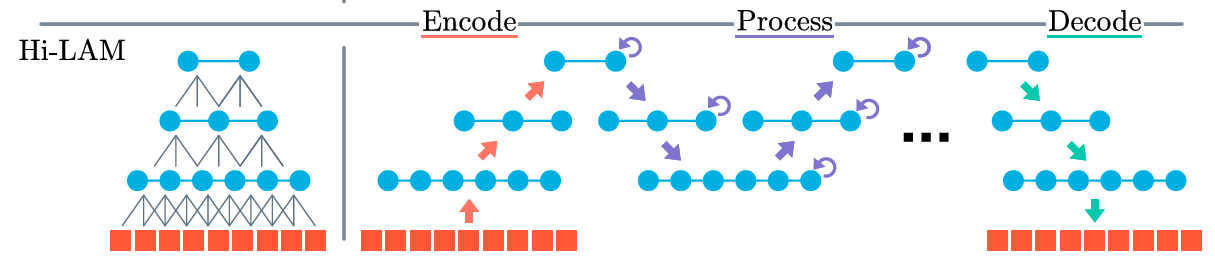

Notably, you should create the **wandb account** via your github. It is useful for you to visualize the process of the modelling and check the initial results. In the meantime, the training epochs are set up as 100 to save the time. Certainly, you can extend it to more epochs (e.g. 200).

In [ ]:
# Set up the working path, then get the grid features
import os
os.chdir('/content/drive/MyDrive/neural-lam-prob_model_lam/neural_lam')

!python create_grid_features.py

In [ ]:
# Get the parameter weights
!python /content/drive/MyDrive/neural-lam-prob_model_lam/create_parameter_weights.py

In [ ]:
# Get the multi-scale graphs
!python create_mesh.py --graph multiscale

In [ ]:
# Get the hierarchical graphs
# A hierarchical graph can have multiple levels.
# It uses hierarchy to represent the same environment at different levels of details and can potentially reduce exponential complexity problems.

!python create_mesh.py --graph hierarchical --hierarchical 1 --levels 3

In [ ]:
# Graphcast model
!python /content/drive/MyDrive/neural-lam-prob_model_lam/train_model.py --model graphcast

In [ ]:
# Deterministic graph-based forecasting model that uses a hierarchical mesh graph and performs sequential message passing through the hierarchy during processing
!python /content/drive/MyDrive/neural-lam-prob_model_lam/train_model.py --model graph_fm --graph hierarchical

### Q5: Model evaluation

After training the models, we should evaluate the GNN models as normal.

Thus, you should check the performance of GraphCast model and Graph-FM model on the validation and test data. Then you can show the **matrix of RMSE** and one beloning to steps of your model results.

The visualization of test loss (leading time 57h) as below:

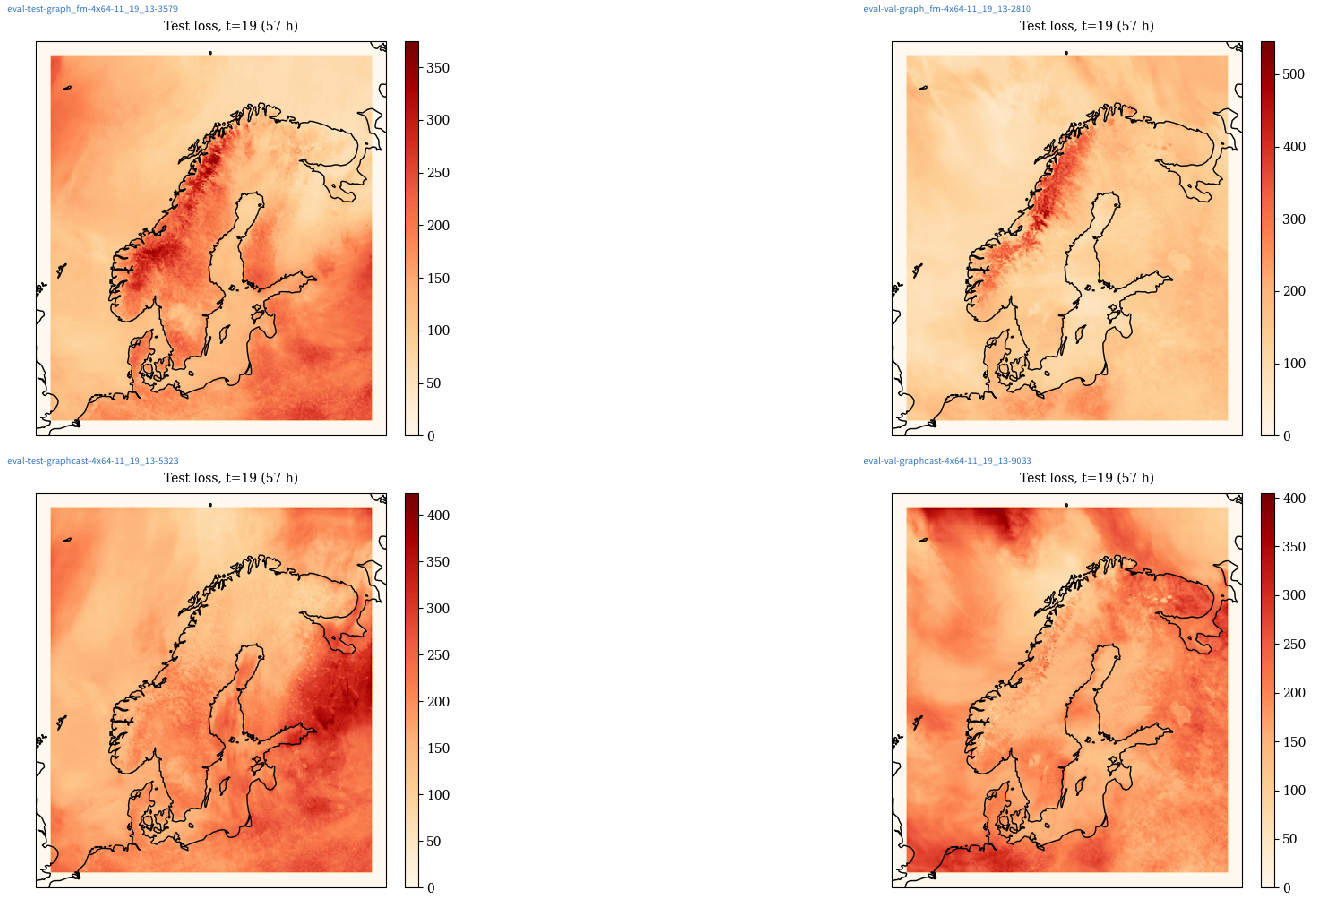

In [ ]:
!python /content/drive/MyDrive/neural-lam-prob_model_lam/train_model.py --model graphcast --eval val

In [ ]:
!python /content/drive/MyDrive/neural-lam-prob_model_lam/train_model.py --model graphcast --eval test

How about your RMSE of your GraphCast model? How is it like?

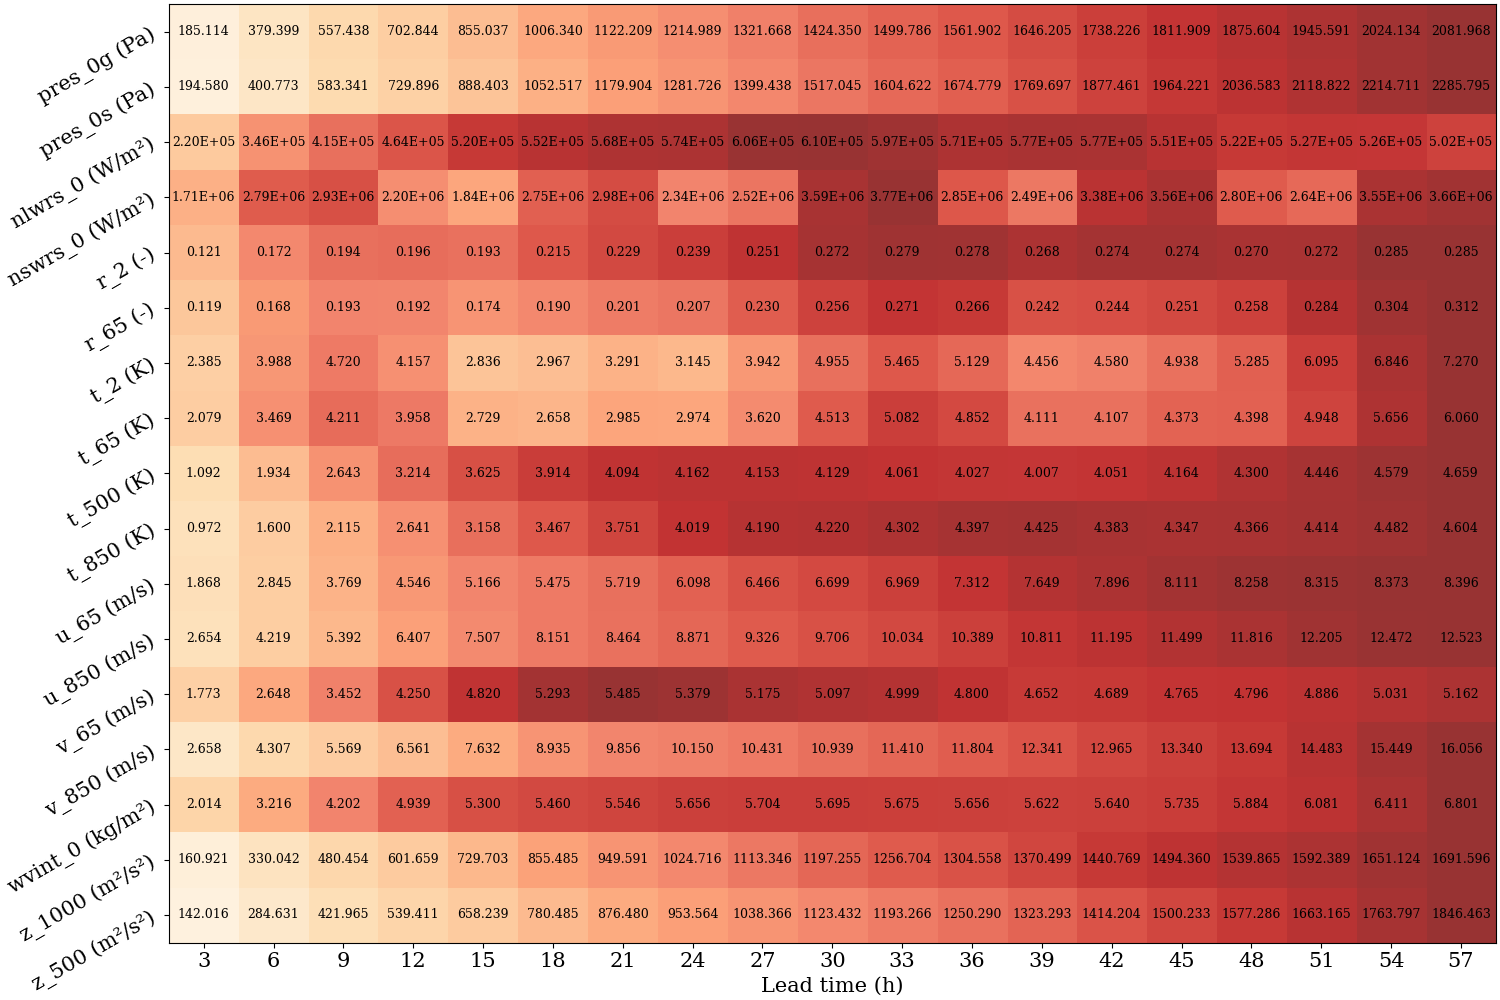

In [ ]:
!python /content/drive/MyDrive/neural-lam-prob_model_lam/train_model.py --model graph_fm --graph hierarchical --eval val

In [ ]:
!python /content/drive/MyDrive/neural-lam-prob_model_lam/train_model.py --model graph_fm --graph hierarchical --eval test

Did you get the similar RMSE for your Graph-FM model as below?

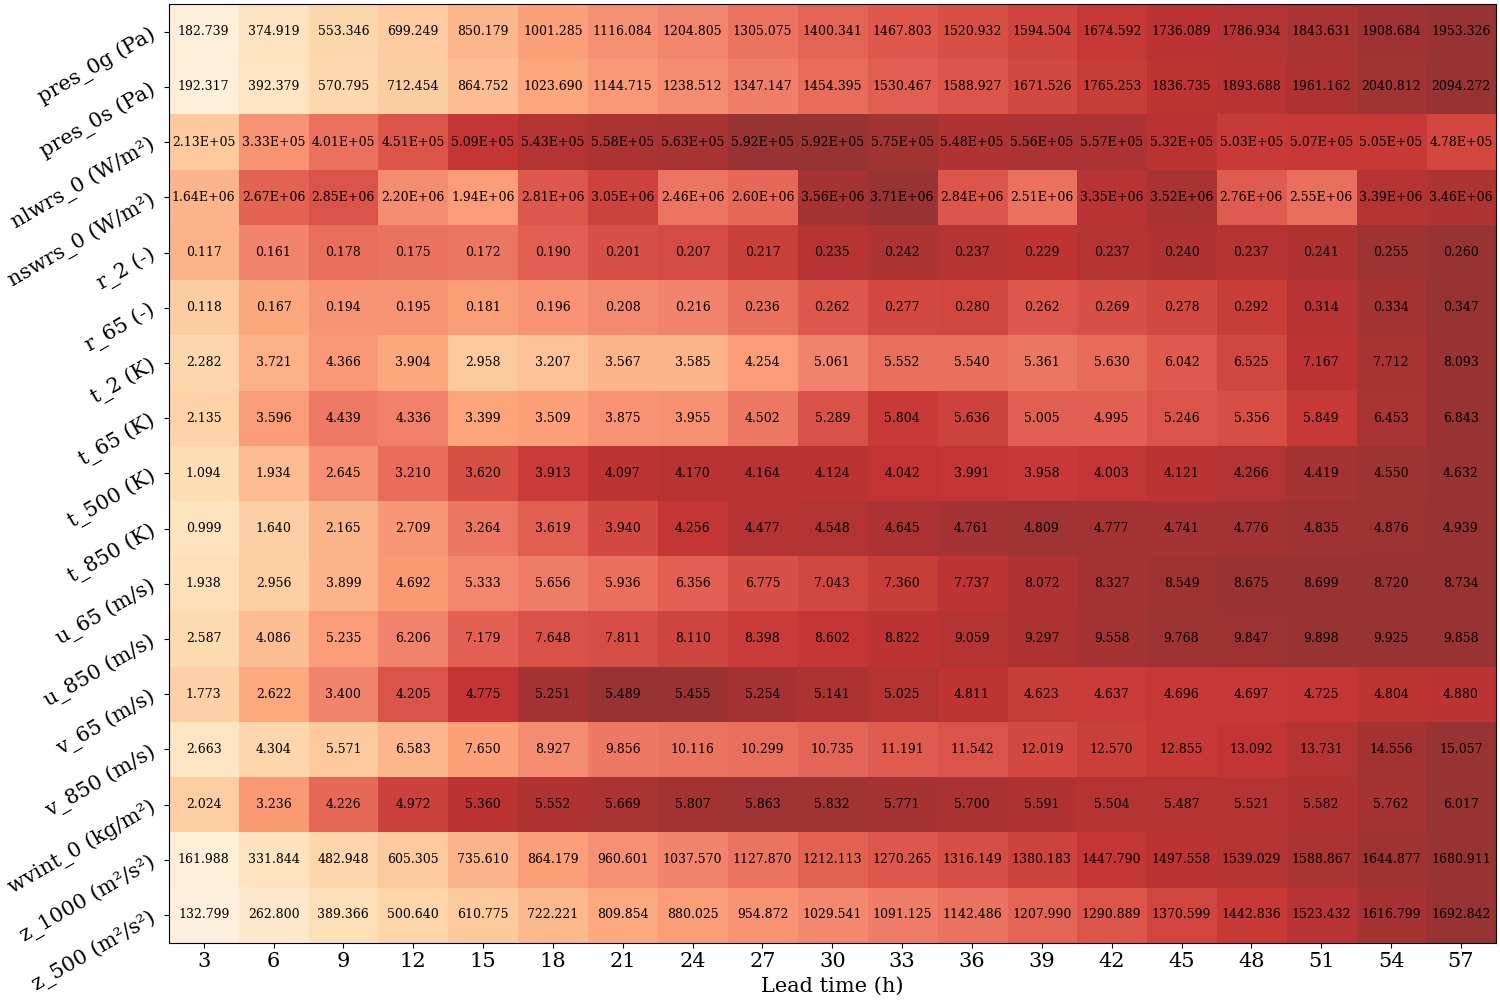

Congratulations! You have completed this exercise for GNN. Now you know how to load the existing models and features to train GNNs to predict weathers. Besides, based on the plots of wandb platform, could you explore and explain more for both models?